# Seasonal Analysis

In [1]:
from dash import Dash, html, dcc, Input, Output
import altair as alt
import dash_bootstrap_components as dbc
import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib.pyplot import figure

import datetime as dt
import calmap
import sheworewhat as sww

alt.data_transformers.disable_max_rows()
alt.renderers.enable('mimetype')
# alt.renderers.enable('notebook')

RendererRegistry.enable('mimetype')

In [71]:
def closet_df(path="../data/ClosetData.csv"):
    """
    Function to import CSV data and return df with unique identifiers.

    Parameters:
    -----------
        path : str
            Path to CSV file containing closet information.

    Returns:
    --------
        closet : pandas.DataFrame
            Dataframe containing 12 columns: ID, Item, Category, Subcategory,
            Color, Pattern, Brand, Bought, Price, 2023, Cost, Name
    """
    # avoid setting with copy warning
    pd.options.mode.chained_assignment = None

    closet = pd.read_csv(path)

    # create IDs per item
    closet = closet.reset_index().rename(columns={"index": "ID"})

    # format strings to create item name
    closet["Item"] = closet["Item"].map(str.title)
    closet["Brand"] = closet["Brand"].map(str.title)
    closet["PrimaryC"] = closet["Color"].str[:5]

    # create item name
    closet["Name"] = (
        closet["ID"].apply(str)
        + " "
        + closet["Brand"]
        + " "
        + closet["Item"]
        + " - "
        + closet["PrimaryC"]
    )

    # NaNs in 2023 addition column
    for i, value in enumerate(closet["2023"]):
        if value != "Yes":
            closet["2023"].iloc[i] = "No"

    return closet

def worn(closet):
    """
    Function to merge raw closet data and collected 2023 data.

    Parameters
    ----------
        closet : pandas.DataFrame
            Dataframe containing complete closet log.

    Returns
    -------
        worn_df : pandas.DataFrame
            Complete and standardized dataframe containing "ID", "Name", "count", "Item",
            "Category", "Sub-Category", "Color", "Pattern", "Brand", "Cost", "2023"
    """

    sheet_url = "https://docs.google.com/spreadsheets/d/1TP7HQZxiP6as_HHexcwkmDTeXOQQOLbUesZjHwKA-Q4/edit?resourcekey#gid=1344494584"
    url_1 = sheet_url.replace("/edit?resourcekey#gid=", "/export?format=csv&gid=")
    form = pd.read_csv(url_1).drop("Timestamp", axis=1).melt("Date").dropna()

    # extract ID number from value
    form["ID"] = form.value.str.extract("(\d+)").astype(int)

    form_counts = (
        form.groupby(["value", "ID"])
        .count()
        .reset_index()
        .rename(columns={"Date": "count"})
        .drop(["variable"], axis=1)
    )

    # left join closet + df
    worn_df = pd.merge(closet, form_counts, how="left", on="ID")
    worn_df["Name"] = worn_df["Brand"] + " " + worn_df["Item"]
    worn_df = worn_df[
        [
            "ID",
            "Name",
            "count",
            "Item",
            "Category",
            "Sub-Category",
            "Color",
            "Pattern",
            "Brand",
            "Bought",
            "Cost",
            "2023",
            "Price",
        ]
    ]
    worn_df = worn_df.fillna(0).rename(columns={"count": "Count"})
    worn_df["Count"] = worn_df["Count"].astype(int)

    return worn_df

## Determine Four Seasons
- idea: see where pandas datetime cuts quarters

In [8]:
pd.Timestamp(dt.date(2016, 2, 29)).quarter

1

In [32]:
def season(day):
    """
    Function to assign season to day of year
    
    Returns:
    --------
        s : str
            Season that day of year in in.
    """
    # March 20 (79th day of year) = Spring Equinox
    if day in range(79, 172): 
        s = "Spring"
    # June 21 (172nd day of year) = Summer Solstice
    elif day in range(172, 265):
        s = "Summer"
    # September 22 (265 day of year) = Fall Equinox
    elif day in range(265, 355):
        s = "Fall"
    # December 21 (355th day of year) = Winter Solstice
    # also need to include Jan 1 - March 19, 2023
    else:
        s ="Winter"
    # also need to include Jan 1 - March 19, 2023

    return s


In [10]:
def fetch_data():
    """
    Function to fetch data from Google Sheet.
    
    Returns:
    --------
    
    """
    sheet_url = "https://docs.google.com/spreadsheets/d/1TP7HQZxiP6as_HHexcwkmDTeXOQQOLbUesZjHwKA-Q4/edit?resourcekey#gid=1344494584"
    url_1 = sheet_url.replace('/edit?resourcekey#gid=', '/export?format=csv&gid=')
    df = pd.read_csv(url_1).drop("Timestamp", axis=1).melt("Date").dropna()

    df["Date"] = pd.to_datetime(df["Date"])
    df["ID"] = df.value.str.extract("(\d+)").astype(int)
    df = df[df.variable != "Note"] # drop notes to self 
    
    return df

In [22]:
df = fetch_data()
new = {"Date" : "2023-06-22 00:00:00", "variable" : "Accessory4", "value" :"94 Ray-Ban Sunglasses", "ID" : 94}
df = df.append(new, ignore_index = True)

/var/folders/qh/6chp8sds4c7gybyg8m5n7k3m0000gn/T/ipykernel_8751/2054925861.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new, ignore_index = True)


In [34]:
df["Date"] = pd.to_datetime(df["Date"]) # only needed for notebook
df["Day"] = df["Date"].dt.dayofyear
df["Season"] = df["Day"].map(season)

df.tail(3)

,Date,variable,value,ID,Day,Season
183,2023-01-21,Accessory4,94 Ray-Ban Sunglasses,94,21,Winter
184,2023-01-23,Accessory4,92 Taylor Swift Baseball Cap,92,23,Winter
185,2023-06-22,Accessory4,94 Ray-Ban Sunglasses,94,173,Summer


## Finalized Function

In [52]:
def split_seasons():
    """
    Function to return Google Sheet data parsed by season.
    
    Returns:
        spring : pandas.DataFrame
            Dataframe containing data from March 20, 2023 - June 20, 2023
        summer : pandas.DataFrame
            Dataframe containing data from June 21, 2023 - Sept 21, 2023
        fall : pandas.DataFrame
            Dataframe containing data from Sept 22, 2023 - Dec 20, 2023
        winter : pandas.DataFrame
            Dataframe containing data from January 1, 2023 - March 20, 2023 
            and December 21, 2023 to DEcember 31, 2023
    """
    df = fetch_data()
    df["Day"] = df["Date"].dt.dayofyear
    df["Season"] = df["Day"].map(season)

    spring = df.loc[df['Season']== "Spring"]
    summer = df.loc[df['Season']== "Summer"]
    fall = df.loc[df['Season']== "Fall"]
    winter = df.loc[df['Season']== "Winter"]
    return spring, summer, fall, winter

In [54]:
spring, summer, fall, winter = split_seasons()

In [60]:
closet = sww.closet_df()
df = fetch_data()
df_counts = (
    df.groupby(["value", "ID"])
    .count()
    .reset_index()
    .rename(columns={"Date": "count"})
    .drop(["variable"], axis=1)
)

# left join closet + df
worn_df = pd.merge(closet, df_counts, how="left", on="ID")
worn_df["Name"] = worn_df["Brand"] + " " + worn_df["Item"]
worn_df = worn_df[
    [
        "ID",
        "Name",
        "count",
        "Item",
        "Category",
        "Sub-Category",
        "Color",
        "Pattern",
        "Brand",
        "Bought",
        "Cost",
        "2023",
        "Price",
    ]
]
worn_df = worn_df.fillna(0).rename(columns={"count": "Count"})
worn_df["Count"] = worn_df["Count"].astype(int)
worn_df

,ID,Name,Count,Item,Category,Sub-Category,Color,Pattern,Brand,Bought,Cost,2023,Price
0,0,Zara Turtleneck,1,Turtleneck,Top,Sweater,Black,Plain,Zara,"Secondhand, Thrifted",cheap,No,0.0
1,1,Plisse Tropical Tank,0,Tropical Tank,Top,Tanktop,"Black, Red, Gold",Feather,Plisse,"Secondhand, Thrifted",cheap,No,0.0
2,2,Plisse Leopard Tank,2,Leopard Tank,Top,Tanktop,"Black, Tan",Leopard,Plisse,"Secondhand, Thrifted",cheap,No,15.0
3,3,Aerie Jeans,8,Jeans,Bottom,Pants,Blue,Plain,Aerie,New,cheap,No,50.0
4,4,Free People Shirt,0,Shirt,Top,Shirt,"Black, White",Cheetah,Free People,"Secondhand, Depop",cheap,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,94,Ray-Ban Sunglasses,14,Sunglasses,Accessory,Glasses,"Black, Gold",Plain,Ray-Ban,New,expensive,No,160.0
95,95,H&M Tights,1,Tights,Accessory,Tight,Black,Plain,H&M,New,cheap,No,0.0
96,96,Evcr Workout Tank,3,Workout Tank,Top,Tanktop,"Pink, White",Floral,Evcr,New,cheap,No,0.0
97,97,Aerie Biker Shorts,2,Biker Shorts,Bottom,Shorts,Black,Plain,Aerie,New,cheap,No,0.0


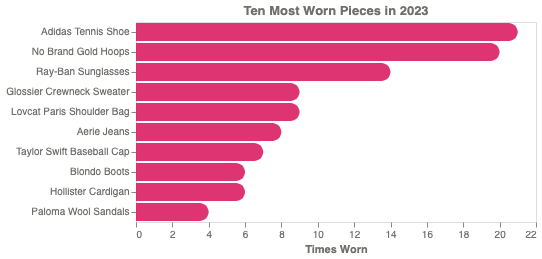

In [63]:
most_worn = worn_df.nlargest(10, columns="Count")
closet_comp = (
    alt.Chart(most_worn, title="Ten Most Worn Pieces in 2023")
    .mark_bar(
        color="#d81159",
        cornerRadiusBottomRight=10,
        cornerRadiusTopRight=10,
        opacity=0.85,
    )
    .encode(
        alt.Y("Name", title="", axis=alt.Axis(labelAngle=-0), sort="-x"),
        alt.X("Count", title="Times Worn", axis=alt.Axis(tickMinStep=1)),
        alt.Tooltip("Count")
    )
    .configure_title(color="#706f6c")
    .configure_axis(
        labelColor="#706f6c", titleColor="#706f6c", grid=False, domain=False
    )
)

closet_comp

# Streamline count function
- this is driving me crazy

In [ ]:
df_counts = (
    df.groupby(["value", "ID"])
    .count()
    .reset_index()
    .rename(columns={"Date": "count"})
    .drop(["variable"], axis=1)
)

# left join closet + df
worn_df = pd.merge(closet, df_counts, how="left", on="ID")
worn_df["Name"] = worn_df["Brand"] + " " + worn_df["Item"]
worn_df = worn_df[
    [
        "ID",
        "Name",
        "count",
        "Item",
        "Category",
        "Sub-Category",
        "Color",
        "Pattern",
        "Brand",
        "Bought",
        "Cost",
        "2023",
        "Price",
    ]
]
worn_df = worn_df.fillna(0).rename(columns={"count": "Count"})
worn_df["Count"] = worn_df["Count"].astype(int)
worn_df

In [72]:
def counts():
    """
    """
    df_counts = (
        df.groupby(["value", "ID"])
        .count()
        .reset_index()
        .rename(columns={"Date": "count"})
        .drop(["variable"], axis=1)
    )

    # left join closet + df
    worn_df = pd.merge(closet, df_counts, how="left", on="ID")
    worn_df["Name"] = worn_df["Brand"] + " " + worn_df["Item"]
    worn_df = worn_df[
        [
            "ID",
            "Name",
            "count",
            "Item",
            "Category",
            "Sub-Category",
            "Color",
            "Pattern",
            "Brand",
            "Bought",
            "Cost",
            "2023",
            "Price",
        ]
    ]
    worn_df = worn_df.fillna(0).rename(columns={"count": "Count"})
    worn_df["Count"] = worn_df["Count"].astype(int)

    return worn_df

In [73]:
counts()

,ID,Name,Count,Item,Category,Sub-Category,Color,Pattern,Brand,Bought,Cost,2023,Price
0,0,Zara Turtleneck,1,Turtleneck,Top,Sweater,Black,Plain,Zara,"Secondhand, Thrifted",cheap,No,0.0
1,1,Plisse Tropical Tank,0,Tropical Tank,Top,Tanktop,"Black, Red, Gold",Feather,Plisse,"Secondhand, Thrifted",cheap,No,0.0
2,2,Plisse Leopard Tank,2,Leopard Tank,Top,Tanktop,"Black, Tan",Leopard,Plisse,"Secondhand, Thrifted",cheap,No,15.0
3,3,Aerie Jeans,8,Jeans,Bottom,Pants,Blue,Plain,Aerie,New,cheap,No,50.0
4,4,Free People Shirt,0,Shirt,Top,Shirt,"Black, White",Cheetah,Free People,"Secondhand, Depop",cheap,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,94,Ray-Ban Sunglasses,14,Sunglasses,Accessory,Glasses,"Black, Gold",Plain,Ray-Ban,New,expensive,No,160.0
95,95,H&M Tights,1,Tights,Accessory,Tight,Black,Plain,H&M,New,cheap,No,0.0
96,96,Evcr Workout Tank,3,Workout Tank,Top,Tanktop,"Pink, White",Floral,Evcr,New,cheap,No,0.0
97,97,Aerie Biker Shorts,2,Biker Shorts,Bottom,Shorts,Black,Plain,Aerie,New,cheap,No,0.0
